In [1]:
from PaperTennis_env import PaperTennisEnv
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os.path
from os import path

In [6]:
#Hyperparms
STRATEGY = 'Mean'
GAMMA = 0.9
ALPHA = 0.1
E_GREEDY = 0.1
NUM_EPISODES = 1000000
OPP_FREQ = 1
mean_window = 10000

# Get Strategy index
Strategies = {
    "Mean": 1,
    "Long": 2,
    "Short": 3,
    "Rand": 4,
    "Combo": 5
}

# Generate opponent startegy vector
if Strategies[STRATEGY] == 5:
    OPP_Strat = np.around(np.random.uniform(0,3,int(NUM_EPISODES/OPP_FREQ))+1)
    OPP_Strat = np.repeat(OPP_Strat, OPP_FREQ)
else: 
    OPP_Strat = np.repeat(Strategies[STRATEGY], NUM_EPISODES)


In [3]:
# Get action e-greedy
def get_action(state,Q_val):
    if state[1] == 0:
        return 0

    p_epsilon = np.random.uniform(0,1)
    if p_epsilon < E_GREEDY:
        return np.argmax(np.random.uniform(0,1,(1,state[1]))) + 1

    q_s = np.zeros(state[1])

    for i in range(1,state[1]):
        q_s[i] = Q_val[state[0],state[1],state[2],i]

    return np.argmax(q_s) + 1

In [5]:
start_time = time.time()

# Init Q table and train history
Q_val = np.zeros([5,51,51,50])
train_episodes = 0

# Init Env
env = PaperTennisEnv()

# Plotting Stuff
trend_wins = np.zeros(NUM_EPISODES-100)
trend_TD = np.zeros(NUM_EPISODES-100)

wins = np.zeros(NUM_EPISODES)
td_error = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    env.reset()
    state = env.state
    done = False

    action = get_action(state,Q_val)

    # Generate an episode
    error_episode = 0
    while not done:

        state_prime, reward, done,_= env.step(action,OPP_Strat[episode])

        action_prime = get_action(state_prime,Q_val)

        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime[0],state_prime[1],state_prime[2],action_prime-1]
            -Q_val[state[0],state[1],state[2],action-1])

        Q_val[state[0],state[1],state[2],action-1] = Q_val[state[0],state[1],state[2],action-1] + ALPHA*TD_error

        error_episode += abs(TD_error)

        state  = state_prime
        action = action_prime

        if (done and reward == 1): wins[episode] = 1
            
    # Track progress
    td_error[episode] = error_episode
    if episode >= 100: trend_wins[episode-100] = np.sum(wins[episode-100:episode])
    
    if episode%100000 == 0: print("Episode %d completed with reward %d" % (episode, reward))

# Update total episode count
train_episodes += episode +1 
        
# Save Q-val Table and episode count
pickle.dump([train_episodes,Q_val], open('TrainedModels/' + STRATEGY + '_SARSA_QT.p', "wb" ))

# Print run details
print("--- %s seconds ---" % (time.time() - start_time))
print("Final mean win percent = %s " % (np.mean(trend_wins[-10000:])))
print("Total Episodes %s " % (train_episodes))

Episode 0 completed with reward -1
Episode 100000 completed with reward 1
Episode 200000 completed with reward -1
Episode 300000 completed with reward 1
Episode 400000 completed with reward -1
Episode 500000 completed with reward 1
Episode 600000 completed with reward 1
Episode 700000 completed with reward 1
Episode 800000 completed with reward 1
Episode 900000 completed with reward 1
--- 175.83372592926025 seconds ---
Final mean win percent = 88.828 
Total Episodes 1000000 


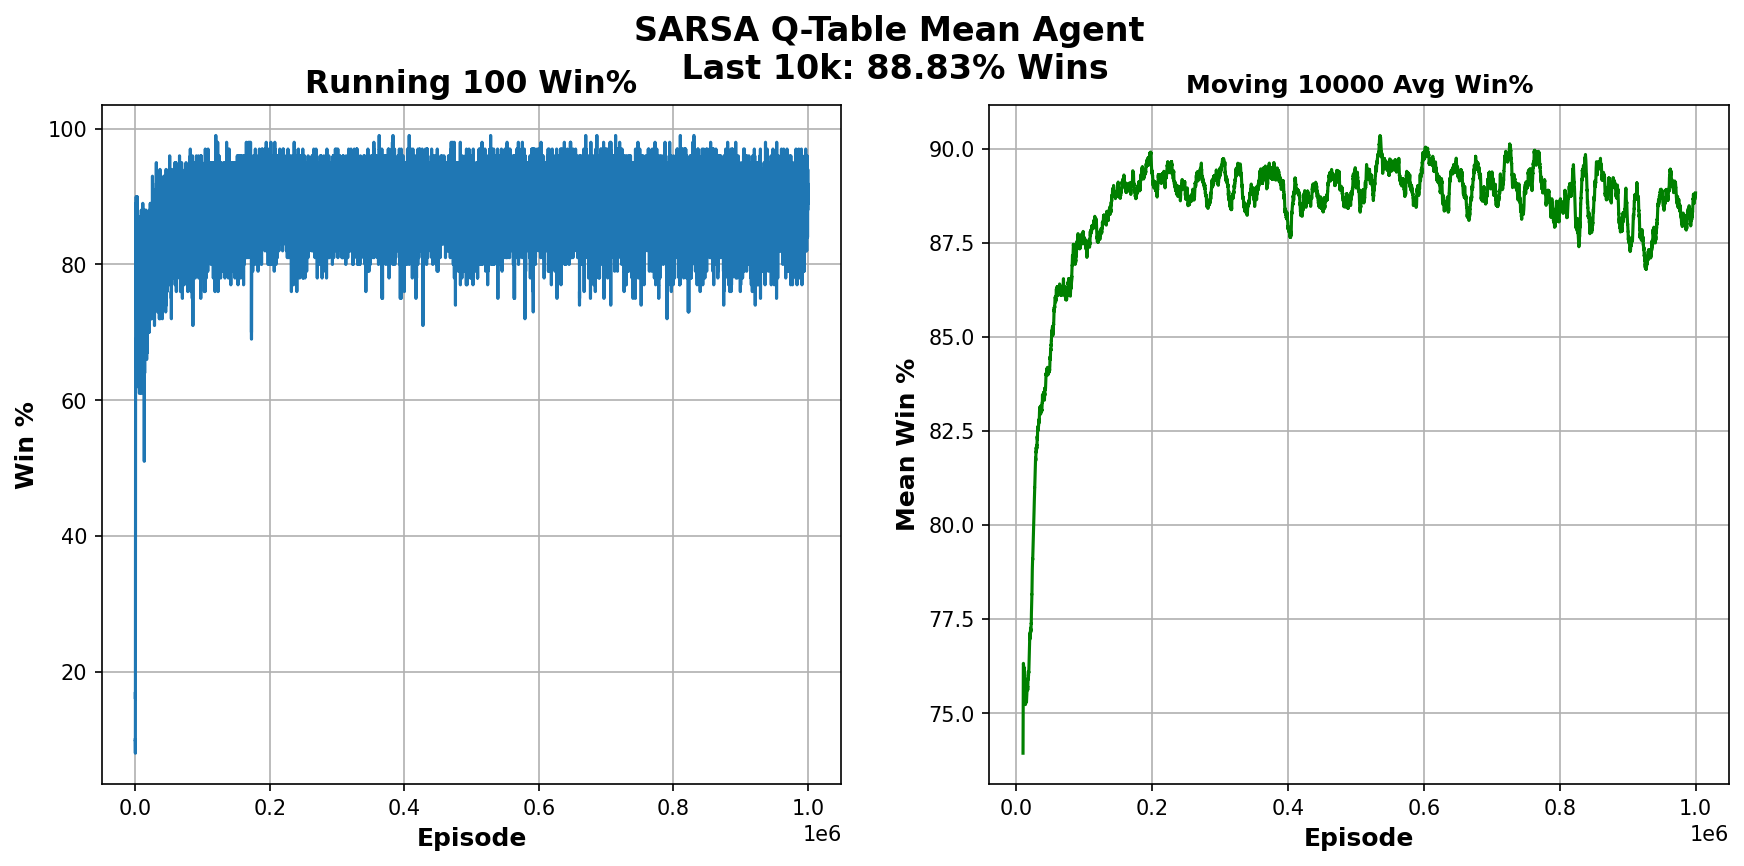

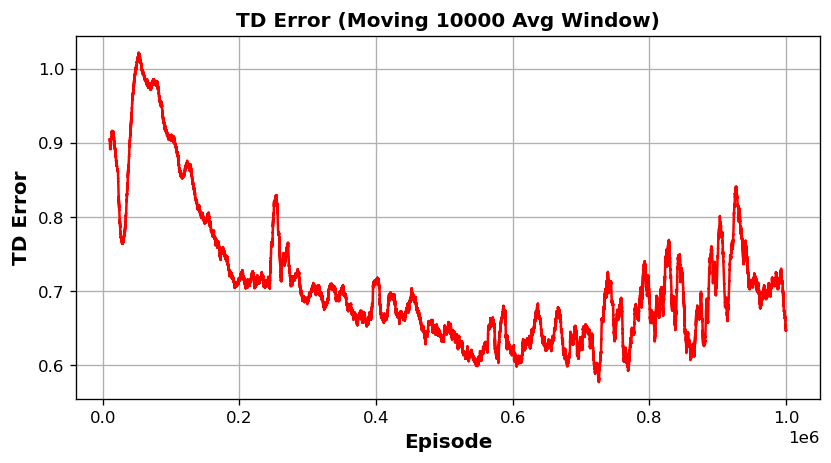

In [11]:
add_info = ''

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6), dpi= 150, facecolor='w', edgecolor='k')
fig.suptitle('SARSA Q-Table {} Agent\n Last 10k: {:.2f}% Wins'.format(STRATEGY,(np.mean(trend_wins[-10000:]))),fontweight='bold',fontsize = 16)

ax1.plot(range(100,NUM_EPISODES),trend_wins)
ax1.set_title('Running 100 Win%',fontweight='bold',fontsize = 15)
ax1.set_xlabel('Episode',fontweight='bold',fontsize = 12)
ax1.set_ylabel('Win %',fontweight='bold',fontsize = 12)
ax1.grid()

ax2.plot(range(mean_window-1,len(trend_wins)), np.convolve(trend_wins, np.ones(mean_window)/mean_window, mode='valid'),c='g')
ax2.set_title('Moving 10000 Avg Win%', fontweight='bold',fontsize = 12)
ax2.set_xlabel('Episode', fontweight='bold',fontsize = 12)
ax2.set_ylabel('Mean Win %', fontweight='bold',fontsize = 12)
ax2.grid()

if Strategies[STRATEGY] == 5:
    ax3 = ax1.twinx()
    ax3.plot(range(100,NUM_EPISODES),OPP_Strat[100:] , 'r-',alpha=0.3)
    ax3.set_ylabel('Strategy', color='r')

fig2, ax4 = plt.subplots(figsize=(8,4), dpi= 120, facecolor='w', edgecolor='k')
ax4.plot(range(mean_window-1,len(td_error)), np.convolve(td_error, np.ones(mean_window)/mean_window, mode='valid'),c='r')
ax4.set_title('TD Error (Moving 10000 Avg Window)', fontweight='bold',fontsize = 15)
ax4.set_xlabel('Episode', fontweight='bold',fontsize = 12)
ax4.set_ylabel('TD Error', fontweight='bold',fontsize = 12)
ax4.grid()

fig.savefig('TrainResults/' + STRATEGY + '_SARSA_QT_Train.png')
fig2.savefig('TrainResults/' + STRATEGY + '_SARSA_QT_TD.png')
plt.show()